## Project description

A company producing fiber optic sensors decided to implement the concept
of Industry 4.0 in one of their production processes. They are going to
implement the AI techniques to automate verification of produced sensors.
Currently, after the production of the sensor, its characteristics should be
verified each time in three reference substances in order to configure:
● Air
● Water
● Isopropanol
After the procedure in the laboratory they collected three spectroscopic
signals. Unfortunately, such procedures are extremely time consuming and
require large human resources. Therefore they are planning to implement AI
algorithms in order to predict characteristics (or any other parameters – you
can propose something) of a working sensor in water and isopropanol based
on measured characteristics in air. It will enable to reduce validation process
only to measurements in the air, but other characteristics will be collected
based on the proposed model.

Data is provided in separate folders from 10 sensors. Each folder contains 3 .txt files and their names refers to previously mentioned reference substances. Each .txt file contains 2 two-dimensional signal (signal wavelength, signal amplitude).

## Goal

My goal is to predict characteristics of a working sensor in water and isopropanol based
on measured characteristics in air.
I am not a specialist if it comes to optics, therefore it would be difficult to perform some data enrichment, so I'll try to operate on given data only.

In [1]:
from glob import glob
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor


from xgboost import XGBRegressor

## Data collection

In [2]:
DATA_ROOT = "data"

In [3]:
filepath_list = glob(DATA_ROOT+"/*/*")

In [4]:
dfs = defaultdict(list)

for filepath in filepath_list:
    temp_df = pd.read_csv(filepath, names=['signal wavelength', 'signal amplitude'])
    filename = filepath.split("/")[-1]
    substance = filename.split(".")[0].split("_")[-1]
    sensor = filename.split(".")[0].split("_")[0][-2:]

    temp_df['sensor'] = int(sensor)

    dfs[substance].append(temp_df)

df_air = pd.concat(dfs["air"])
df_water = pd.concat(dfs["water"])
df_izopropanol = pd.concat(dfs["izopropanol"])

df_air.reset_index(drop=True, inplace=True)
df_water.reset_index(drop=True, inplace=True)
df_izopropanol.reset_index(drop=True, inplace=True)

In [5]:
df_air.describe()

,signal wavelength,signal amplitude,sensor
count,3.001000e+04,30010.000000,30010.000000
mean,1.500000e-06,0.799809,5.500000
std,8.663285e-08,4.903714,2.872329
min,1.350000e-06,-8.798200,1.000000
25%,1.425000e-06,-3.203700,3.000000
50%,1.500000e-06,1.009450,5.500000
75%,1.575000e-06,4.794300,8.000000
max,1.650000e-06,10.003000,10.000000


In [6]:
df_water.describe()

,signal wavelength,signal amplitude,sensor
count,3.001000e+04,30010.000000,30010.000000
mean,1.500000e-06,-1.717725,5.500000
std,8.663285e-08,6.560504,2.872329
min,1.350000e-06,-14.673000,1.000000
25%,1.425000e-06,-6.825600,3.000000
50%,1.500000e-06,-1.859100,5.500000
75%,1.575000e-06,4.331600,8.000000
max,1.650000e-06,9.284900,10.000000


In [7]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30010 entries, 0 to 30009
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   signal wavelength  30010 non-null  float64
 1   signal amplitude   30010 non-null  float64
 2   sensor             30010 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 703.5 KB


In [8]:
def plot_all_surfaces(
        air_df, water_df, izo_df, sensor_number=None
):
    if sensor_number:
        air_df=air_df[air_df["sensor"] == sensor_number]
        water_df=water_df[water_df["sensor"] == sensor_number]
        izo_df=izo_df[izo_df["sensor"] == sensor_number]
        title_label = f"Sensor {sensor_number}"
    else:
        title_label = "All sensors"
    plt.scatter(air_df["signal wavelength"], air_df["signal amplitude"], label="air", s=1)
    plt.scatter(water_df["signal wavelength"], water_df["signal amplitude"], label="water", s=1)
    plt.scatter(izo_df["signal wavelength"], izo_df["signal amplitude"], label="izopropanol", s=1)
    plt.legend()
    plt.xlabel("signal wavelength")
    plt.ylabel("signal amplitude")
    plt.title(title_label)
    plt.show()

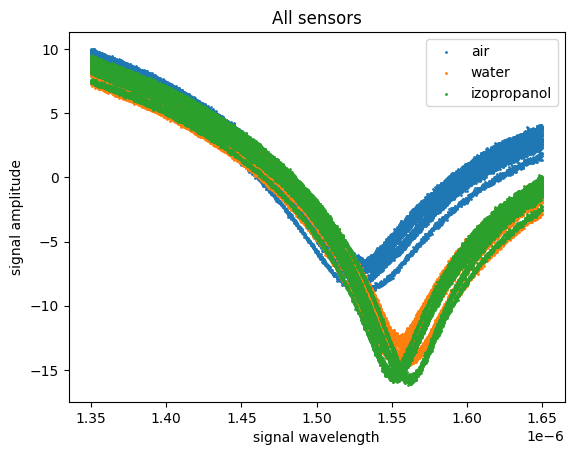

In [9]:
plot_all_surfaces(df_air, df_water, df_izopropanol)

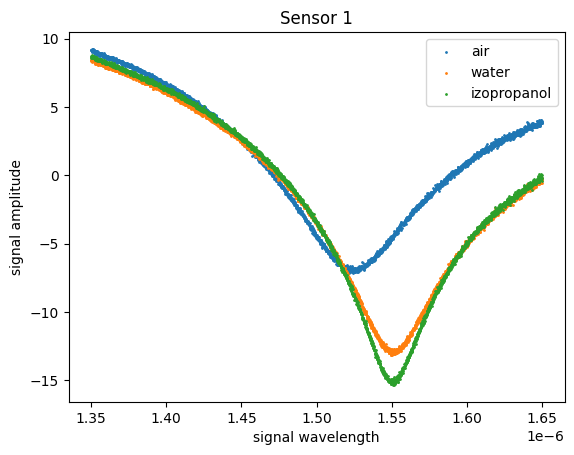

In [10]:
plot_all_surfaces(df_air, df_water, df_izopropanol, 1)

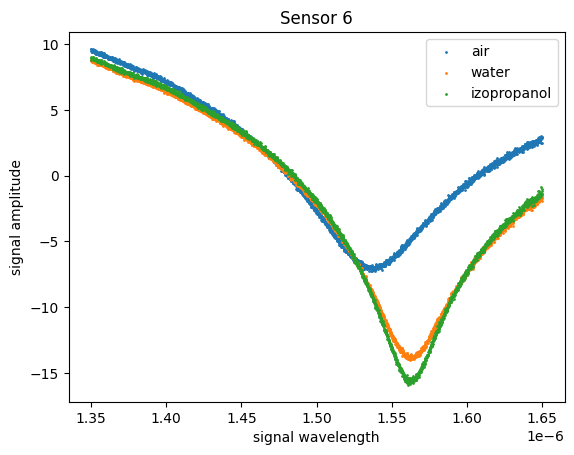

In [11]:
plot_all_surfaces(df_air, df_water, df_izopropanol, 6)

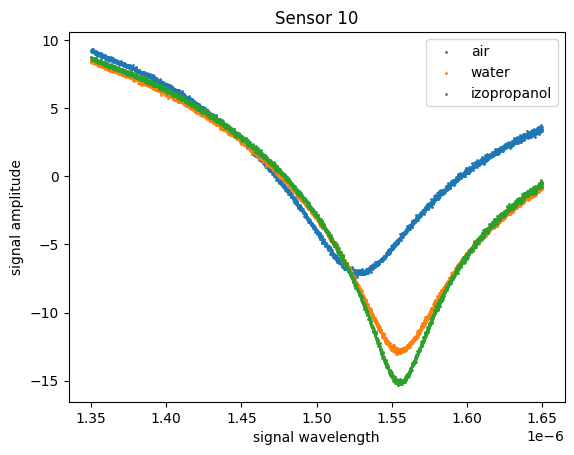

In [12]:
plot_all_surfaces(df_air, df_water, df_izopropanol, 10)

Data from each sensor seems to be strongly correlated, so hopefully we can correctly predict signal amplitude within water and izopropanol.

## Preparing data for models

In [13]:
df_air.rename(columns={"signal amplitude": "air amplitude"}, inplace=True)
df_water.rename(columns={"signal amplitude": "water amplitude"}, inplace=True)
df_izopropanol.rename(columns={"signal amplitude": "izopropanol amplitude"}, inplace=True)

In [14]:
df = pd.merge(df_air, df_water, on=["signal wavelength", "sensor"])
df = pd.merge(df, df_izopropanol, on=["signal wavelength", "sensor"])

In [15]:
df.head()

,signal wavelength,air amplitude,sensor,water amplitude,izopropanol amplitude
0,0.000001,9.1792,1,8.3570,8.5551
1,0.000001,9.2003,1,8.4287,8.6750
2,0.000001,9.1968,1,8.4422,8.7116
3,0.000001,9.1028,1,8.4144,8.7157
4,0.000001,9.0601,1,8.4034,8.6792


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30010 entries, 0 to 30009
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   signal wavelength      30010 non-null  float64
 1   air amplitude          30010 non-null  float64
 2   sensor                 30010 non-null  int64  
 3   water amplitude        30010 non-null  float64
 4   izopropanol amplitude  30010 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.4 MB


In [17]:
X = df_air
y = df.iloc[:, 3:]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train.head()

,signal wavelength,air amplitude,sensor
10608,0.000002,-6.1456,4
29930,0.000002,2.8418,10
2210,0.000002,-1.8291,1
14242,0.000002,-3.0784,5
23114,0.000002,-3.5828,8


In [20]:
y_train.head()

,water amplitude,izopropanol amplitude
10608,-5.1979,-4.9787
29930,-1.6603,-1.1306
2210,-9.8734,-10.5480
14242,-12.5700,-13.5450
23114,-12.1510,-14.2610


## Models

### Linear regression

In [21]:
lm = LinearRegression()

In [22]:
lm.fit(X_train, y_train)

LinearRegression()

In [23]:
predictions = lm.predict(X_test)

In [24]:
def plot_real_and_predicted_data(x_t, y_t, pred, surface="water"):
    x_axis = x_t["signal wavelength"]

    if surface == "water":
        y_t = y_t.iloc[:,0]
        pred = pred[:,0]
    elif surface == "izopropanol":
        y_t = y_t.iloc[:,1]
        pred = pred[:,1]
    else:
        raise ValueError("Wrong surface name. Choose: 'water' or 'izopropanol'")

    plt.scatter(x_axis, y_t, label=f"{surface} amplitude", s=1)
    plt.scatter(x_axis, pred, label=f"{surface} amplitude predictions", s=1)
    plt.legend()
    plt.xlabel("signal wavelength")
    plt.ylabel("signal amplitude")
    plt.show()

In [25]:
def evaluate_model(y_t, pred):
    return {
        "R^2": r2_score(y_t, pred),
        "Mean absolute error": mean_absolute_error(y_t, pred),
        "Mean squared error": mean_squared_error(y_t, pred),
    }

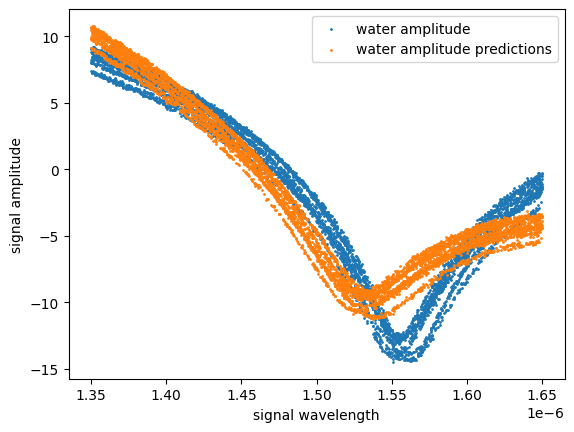

In [28]:
plot_real_and_predicted_data(X_test, y_test, predictions)

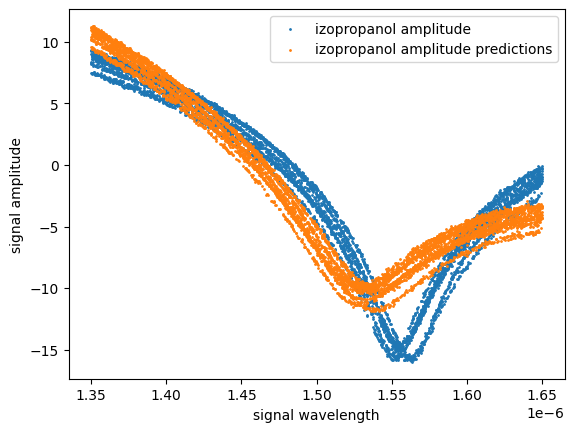

In [32]:
plot_real_and_predicted_data(X_test, y_test, predictions, surface="izopropanol")

In [29]:
evaluate_model(y_test, predictions)

{'R^2': 0.8799174633246358,
 'Mean absolute error': 1.8783080856301893,
 'Mean squared error': 5.505793716057713}


### Random forrest

In [33]:
rf = RandomForestRegressor()

In [34]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [35]:
predictions = rf.predict(X_test)

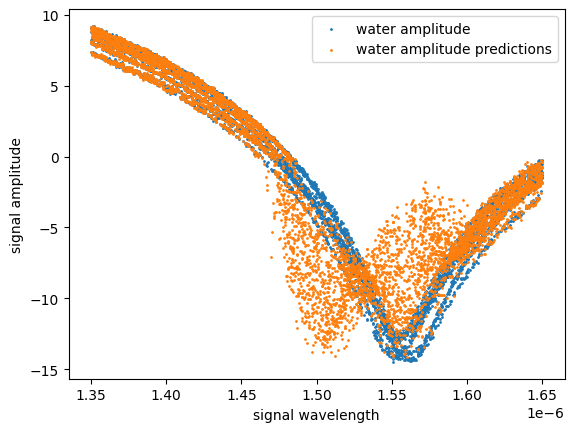

In [36]:
plot_real_and_predicted_data(X_test, y_test, predictions)

In [37]:
evaluate_model(y_test, predictions)

{'R^2': 0.8270670029636542,
 'Mean absolute error': 1.453327901669034,
 'Mean squared error': 7.919431198043945}

In [38]:
random_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 30, 50, 70, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 400, 600]
}

In [39]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [40]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  17.0s


/home/mardzien/PycharmProjects/ML_project/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  18.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   6.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   6.2s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  26.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=False, max_depth=100, min_samples_le

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 30, 50, 70, 100,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400, 600]},
                   random_state=42, verbose=2)

In [41]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'bootstrap': True}

In [42]:
model = RandomForestRegressor(**rf_random.best_params_)

In [43]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [44]:
predictions = model.predict(X_test)

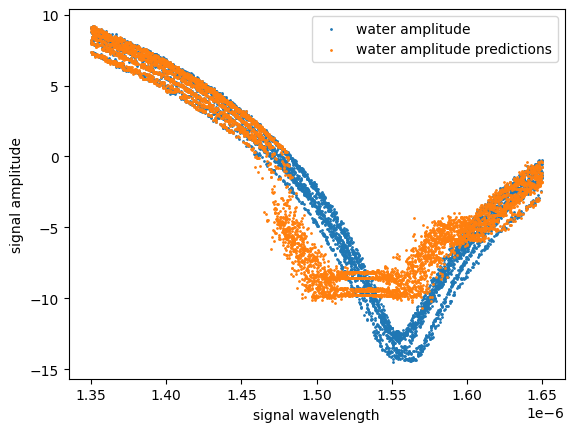

In [45]:
plot_real_and_predicted_data(X_test, y_test, predictions)

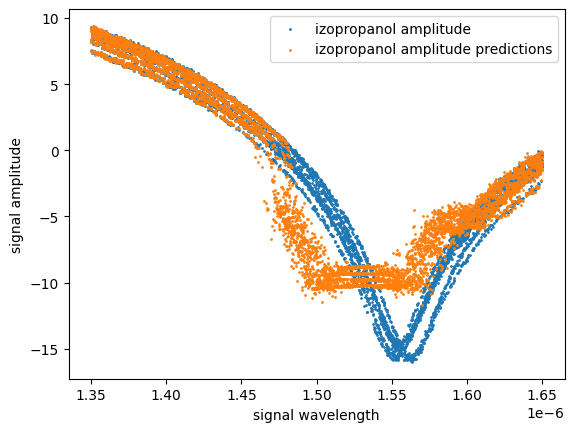

In [46]:
plot_real_and_predicted_data(X_test, y_test, predictions, surface="izopropanol")

In [47]:
evaluate_model(y_test, predictions)

{'R^2': 0.8542979652143121,
 'Mean absolute error': 1.590059106253986,
 'Mean squared error': 6.66823570538337}

As We can see neither Linear regression nor Random forest regressor seem to be a good option. Linear regression has different curve and angle, random forest regression seems to be a good option for certain signal wavelengths, but it's completely off in the middle of wavelengths. Let's try out other algorithms

### XGBoost

In [49]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

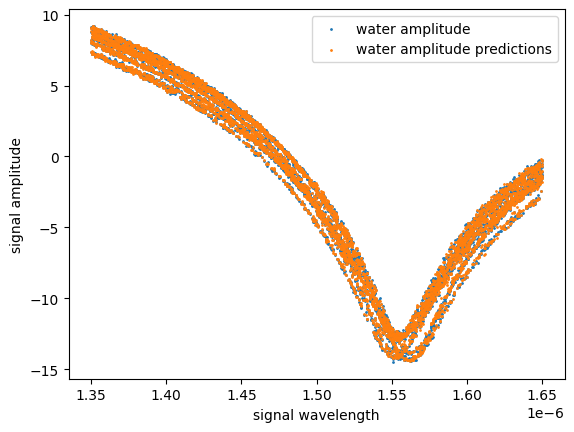

In [50]:
plot_real_and_predicted_data(X_test, y_test, predictions)

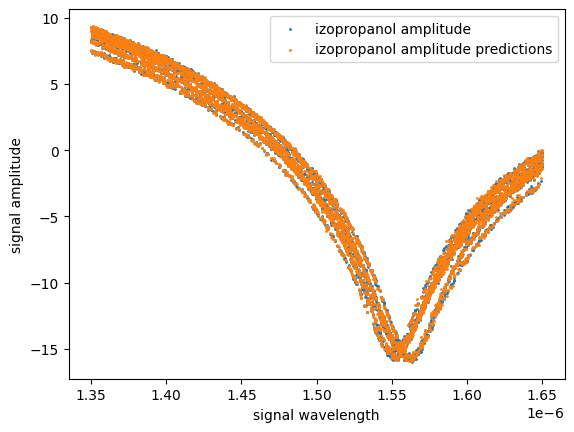

In [51]:
plot_real_and_predicted_data(X_test, y_test, predictions, surface="izopropanol")

In [52]:
evaluate_model(y_test, predictions)

{'R^2': 0.9996866213692572,
 'Mean absolute error': 0.09092157052654595,
 'Mean squared error': 0.014277658414819802}

As We can see XGBoost performs really good! It distinguishes sensors, and correctly predicts signal amplitude across entire spectrum of signal wavelength!

## Conclusion

Now we can save our model and use it to predict amplitude characteristics within water and izopropanol. Of course We can improve our results, for example we can build model based on ddn, we can add more features by consulting it witch optics specialist to achieve better results!